In [6]:
%matplotlib notebook
import numpy as np
from scipy.signal import welch
import matplotlib.pyplot as plt
from scipy.stats import circstd

from kalman_experiments import SSPE
from kalman_experiments.models import MatsudaParams, SingleRhythmModel, collect, gen_ar_noise_coefficients, ArNoise
from kalman_experiments.kalman import PerturbedP1DMatsudaKF, apply_kf

In [100]:
SRATE = 1000
DURATION = 100
FREQ_GT = 6
SIGNAL_SIGMA_GT = np.sqrt(10)
NOISE_SIGMA_GT = 1
A_GT = 0.99
ALPHA = 1.5
NOISE_AR_ORDER = 1000

data = {}
phases = {}

data["sines_in_white"], phases["sines_in_white"] = SSPE.generate_sines_w_white(DURATION, SRATE)
data["sines_in_pink"], phases["sines_in_pink"] = SSPE.generate_sines_w_pink(DURATION, SRATE)
data["filtered_pink"], phases["filtered_pink"] = SSPE.generate_filtered_pink_noise_with_added_pink_noise(DURATION, SRATE)

mp = MatsudaParams(A_GT, FREQ_GT, SRATE)
oscillation_model = SingleRhythmModel(mp, sigma=SIGNAL_SIGMA_GT)
gt_states = collect(oscillation_model, DURATION * SRATE)

noise_model = ArNoise(x0=np.random.rand(NOISE_AR_ORDER), alpha=ALPHA, order=NOISE_AR_ORDER, s=NOISE_SIGMA_GT/5)
noise_sim = collect(noise_model, DURATION * SRATE)
pink_noise_sspe = SSPE.make_pink_noise(ALPHA, DURATION * SRATE, 1/SRATE)
white_noise_sspe = NOISE_SIGMA_GT * np.random.randn(DURATION * SRATE)
data["state_space_model"] = np.real(gt_states) + white_noise_sspe
# data["state_space_model"] = np.real(gt_states) + noise_sim
# data["state_space_model"] = np.real(gt_states) + 10 * pink_noise_sspe # NOISE_SIGMA_GT * SSPE.make_pink_noise(ALPHA, DURATION * SRATE, 1/SRATE)
phases["state_space_model"] = np.angle(gt_states)

<IPython.core.display.Javascript object>


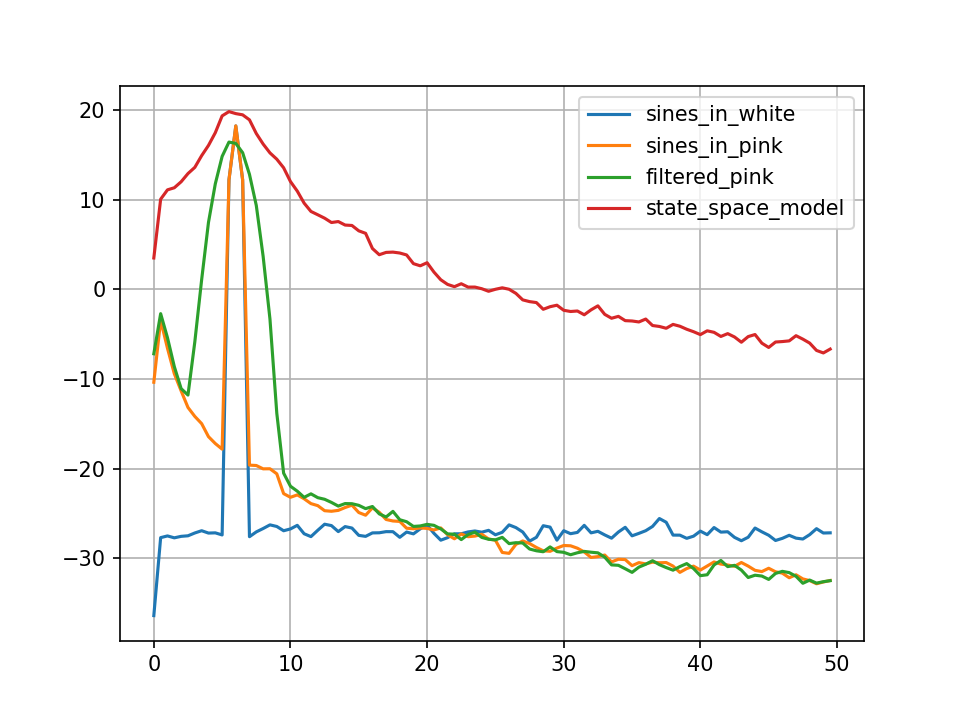

In [101]:
FREQ_LIM = 100

plt.figure()
for k, d in data.items():
    freqs, psd = welch(d, fs=SRATE, nperseg=2000)
    plt.plot(freqs[:FREQ_LIM], 10 * np.log10(psd[:FREQ_LIM]), label=k)
plt.grid()
plt.legend()
plt.show()

In [120]:
# Setup filters

A_KF = A_GT
FREQ_KF = FREQ_GT
SIGNAL_SIGMA_KF = SIGNAL_SIGMA_GT
NOISE_SIGMA_KF = NOISE_SIGMA_GT

# kf = Difference1DMatsudaKF(A=A_KF, f=FREQ_KF, sr=SRATE, q_s=SIGNAL_SIGMA_KF, psi=PSI, r_s=NOISE_SIGMA_KF)
# kf = PerturbedP1DMatsudaKF(
#     A=A_KF, f=FREQ_KF, sr=SRATE, q_s=SIGNAL_SIGMA_KF, psi=noise_model.a, r_s=NOISE_SIGMA_KF, lambda_=0
# )
a = gen_ar_noise_coefficients(alpha=ALPHA, order=100)
b = gen_ar_noise_coefficients(alpha=0, order=30)
mp = MatsudaParams(A_KF, FREQ_KF, SRATE)
kf_pink = PerturbedP1DMatsudaKF(mp, q_s=SIGNAL_SIGMA_KF * 0, psi=a, r_s=NOISE_SIGMA_KF / 5, lambda_=1e-6)
kf_white = PerturbedP1DMatsudaKF(mp, q_s=SIGNAL_SIGMA_KF, psi=np.array([0]), r_s=NOISE_SIGMA_KF, lambda_=0)

In [121]:
print(" " * 18, "Pink KF", "White KF")
for k in data:
#     if k != "state_space_model":
#         continue
    filtered_pink = apply_kf(kf_pink, data[k], delay=0)
    filtered_white = apply_kf(kf_white, data[k], delay=0)
    cstd_pink = circstd(np.angle(filtered_pink) - phases[k])
    cstd_white = circstd(np.angle(filtered_white) - phases[k])
    print(f"{k:<18}", round(cstd_pink * 180 / np.pi, 2), round(cstd_white * 180 / np.pi,2))

                   Pink KF White KF
sines_in_white     5.55 7.57
sines_in_pink      5.58 10.61
filtered_pink      37.79 17.48
state_space_model  59.41 35.89


In [116]:
f1, d1 = welch(noise_sim, fs=SRATE, nperseg=2000)
f2, d2 = welch(10 * pink_noise_sspe, fs=SRATE, nperseg=2000)
f3, d3 = welch(np.real(gt_states), fs=SRATE, nperseg=2000)
f4, d4 = welch(white_noise_sspe, fs=SRATE, nperseg=2000)

<IPython.core.display.Javascript object>


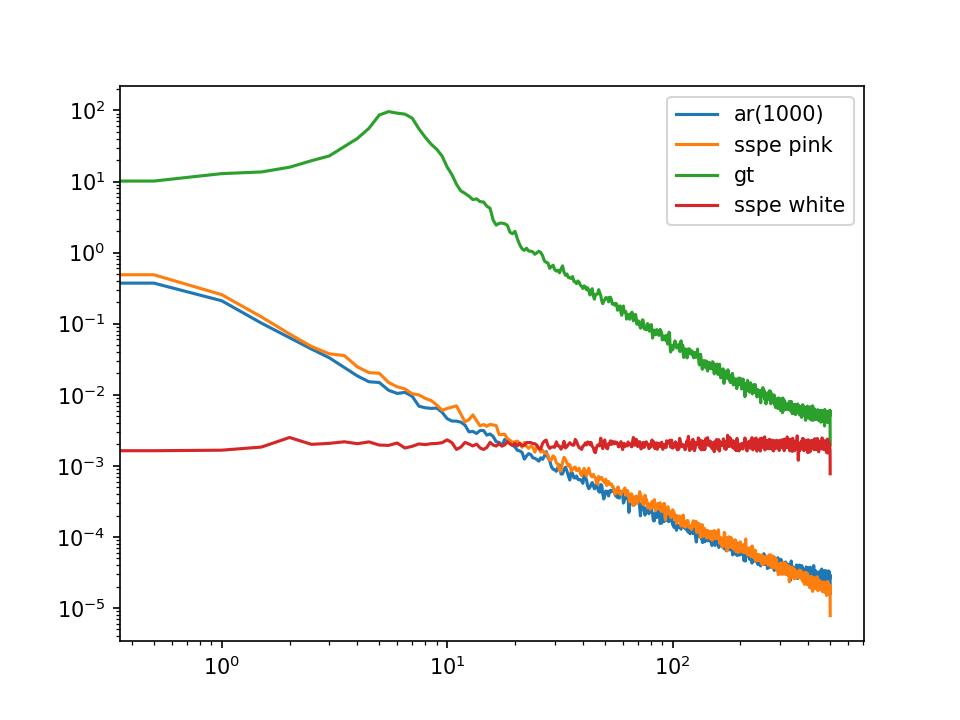

In [117]:
plt.figure()
plt.loglog(f1, d1, label="ar(1000)")
plt.loglog(f1, d2, label="sspe pink")
plt.loglog(f1, d3, label="gt")
plt.loglog(f1, d4, label="sspe white")
plt.legend()
plt.show()